In [2]:
#Instalar pyathena
!pip install pyathena


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
# LA CONSULTA SIGUIENTE ES LA ORIGINAL QUE ENVIÓ ALEX A NIVEL PAYER, COUNTRY, ID_LOCATION Y DATE (POR LAS DUDAS LA CONSERVEMOS)

In [10]:
from pyathena import connect
import pandas as pd
conn = connect(s3_staging_dir='s3://viamericas-datalake-dev-us-east-1-283731589572-athena/queryresults/',
               region_name='us-east-1')

df = pd.read_sql(''' 
SELECT
    RTRIM(b.ID_LOCATION) AS ID_LOCATION,
    'MT' AS ID_PRODUCT,
    CAST(RTRIM(p.NAME_MAIN_BRANCH) AS VARCHAR(60)) AS PAYER,
    RTRIM(co.NAME_COUNTRY) AS COUNTRY,
    'Y' AS "EXISTS",
    'TODAY_DETAILED_HOURLY_DATA_PER_PRODUCT' AS KPI_NAME,
    'Today' AS CATEGORY,
    NULL AS USER,
    CAST(DATE_FORMAT(a.DATE_RECEIVER, '%Y-%m-%d') AS DATE) AS DATE,
    0 AS HOUR,
    SUM(
        CASE
            WHEN A.ID_FLAG_RECEIVER = 'A' THEN 0
            ELSE a.ID_RECEIVER / ABS(a.ID_RECEIVER)
        END
    ) AS COUNT,
    SUM(
        CASE
            WHEN A.ID_FLAG_RECEIVER = 'P' THEN a.ID_RECEIVER
            ELSE 0
        END / ABS(a.ID_RECEIVER)
    ) AS COUNT_PAID,
    (
        SUM(
            A.TELEX_RECEIVER + A.EXCHANGE_RECEIVER + A.TOTAL_MODO_PAGO + A.HANDLING_RECEIVER
        ) - SUM(
            (
                A.TELEX_RECEIVER + A.EXCHANGE_RECEIVER + A.TOTAL_MODO_PAGO
            ) - (
                A.TELEX_COMPANY + A.EXCHANGE_COMPANY + A.TOTAL_MODO_PAGO_COMP + A.HANDLING_RECEIVER
            )
        ) - SUM(COALESCE(a.COMMISSION_PAYEE, 0)) + SUM(COALESCE(A.DISCOUNT, 0))
    ) AS CORE_MARGIN,
	(
		SUM(
			A.TELEX_RECEIVER + A.EXCHANGE_RECEIVER + A.TOTAL_MODO_PAGO + A.HANDLING_RECEIVER
		) - SUM(
			(
				A.TELEX_RECEIVER + A.EXCHANGE_RECEIVER + A.TOTAL_MODO_PAGO
			) - (
				A.TELEX_COMPANY + A.EXCHANGE_COMPANY + A.TOTAL_MODO_PAGO_COMP + A.HANDLING_RECEIVER
			)
		) - SUM(COALESCE(a.COMMISSION_PAYEE, 0)) + SUM(COALESCE(A.DISCOUNT, 0)) + SUM(
		CASE
    WHEN CAST(DATE_TRUNC('YEAR', a.DATE_RECEIVER) AS DATE) < CAST('2018-01-01' AS DATE) THEN
        COALESCE(a.FOREX_GAIN, COALESCE(a.FOREX_ESTIMATED, 0))
    ELSE
        CASE
            WHEN a.FOREX_CALC = 'Y' THEN a.FOREX_GAIN
            ELSE COALESCE(a.FOREX_ESTIMATED, 0)
        END
END
		) - SUM(
    CASE
        WHEN ORIGINAL_RATE <> 0 AND CAST(NET_AMOUNT_RECEIVER * ((ORIGINAL_RATE - RATE_CHANGE_RECEIVER) / ORIGINAL_RATE) AS DECIMAL(10,4)) - FEE_RATE * -1 < 0
        THEN
            CASE
                WHEN COALESCE(ORIGINAL_RATE, -999.999) = -999.999 THEN FEE_RATE * -1
                WHEN COALESCE(ORIGINAL_RATE, 0) = 0 THEN 0
                ELSE CAST(NET_AMOUNT_RECEIVER * ((ORIGINAL_RATE - RATE_CHANGE_RECEIVER) / ORIGINAL_RATE) AS DECIMAL(10,4))
            END
        ELSE CAST(FEE_RATE * -1 AS DECIMAL(12, 2))
    END
) - SUM(CAST(COALESCE(vd.VIADEAL_REAL, COALESCE(vd.VIADEAL_ESTIMATED, 0)) AS DECIMAL(18, 8)))

	) AS GP,
(
    COALESCE(SUM(CASE WHEN A.ID_FLAG_RECEIVER = 'A' THEN 0 ELSE A.TELEX_RECEIVER + A.EXCHANGE_RECEIVER + A.TOTAL_MODO_PAGO + A.HANDLING_RECEIVER END), 0) - --[FEE]
    COALESCE(SUM((A.TELEX_RECEIVER + A.EXCHANGE_RECEIVER + A.TOTAL_MODO_PAGO) - (A.TELEX_COMPANY + A.EXCHANGE_COMPANY + A.TOTAL_MODO_PAGO_COMP + A.HANDLING_RECEIVER)), 0) - --[FEE_AGENT]
    COALESCE(SUM(COALESCE(a.COMMISSION_PAYEE, 0)), 0) + --FEE PAYER
    COALESCE(SUM(COALESCE(A.DISCOUNT, 0)), 0) + --LOYALTY
    COALESCE(SUM(CASE 
        WHEN YEAR(a.DATE_RECEIVER) < 2018 THEN COALESCE(a.FOREX_GAIN, COALESCE(a.FOREX_FIRST_ESTIMATED, 0))
        ELSE CASE WHEN a.FOREX_CALC = 'Y' THEN a.FOREX_GAIN ELSE COALESCE(a.FOREX_FIRST_ESTIMATED, 0) END
    END), 0) - --FOREX
    COALESCE(
        SUM(CASE
            WHEN ORIGINAL_RATE <> 0 AND CAST(NET_AMOUNT_RECEIVER * ((ORIGINAL_RATE - RATE_CHANGE_RECEIVER) / ORIGINAL_RATE) AS DECIMAL(10,4)) - FEE_RATE * -1 < 0
            THEN
                CASE COALESCE(ORIGINAL_RATE, -999.999)
                    WHEN -999.999 THEN FEE_RATE * -1
                    WHEN 0 THEN 0
                    ELSE CAST(NET_AMOUNT_RECEIVER * ((ORIGINAL_RATE - RATE_CHANGE_RECEIVER) / ORIGINAL_RATE) AS DECIMAL(10,4))
                END
            ELSE CAST(FEE_RATE * -1 AS DECIMAL(12, 2)) 
        END),
    0) - --VIATASA
    COALESCE(SUM(CAST(COALESCE(vd.VIADEAL_REAL, COALESCE(vd.VIADEAL_ESTIMATED, 0)) AS DECIMAL(18, 8))), 0) -- VIADEAL
) AS GP_SALES,

CAST(
    CASE
        WHEN SUM(CAST(COALESCE(CASE WHEN A.ID_FLAG_RECEIVER = 'A' THEN 0 ELSE a.ID_RECEIVER END / ABS(a.ID_RECEIVER), 0) AS DECIMAL(10, 0))) > 0
        THEN
            (
                COALESCE(SUM(CASE WHEN A.ID_FLAG_RECEIVER = 'A' THEN 0 ELSE A.TELEX_RECEIVER + A.EXCHANGE_RECEIVER + A.TOTAL_MODO_PAGO + A.HANDLING_RECEIVER END), 0) - --[FEE]
                COALESCE(SUM((A.TELEX_RECEIVER + A.EXCHANGE_RECEIVER + A.TOTAL_MODO_PAGO) - (A.TELEX_COMPANY + A.EXCHANGE_COMPANY + A.TOTAL_MODO_PAGO_COMP + A.HANDLING_RECEIVER)), 0) - --[FEE_AGENT]
                COALESCE(SUM(COALESCE(a.COMMISSION_PAYEE, 0)), 0) + --FEE PAYER
                COALESCE(SUM(COALESCE(A.DISCOUNT, 0)), 0) + --LOYALTY
                COALESCE(SUM(CASE 
                    WHEN YEAR(a.DATE_RECEIVER) < 2018 THEN COALESCE(a.FOREX_GAIN, COALESCE(a.FOREX_ESTIMATED, 0))
                    ELSE CASE WHEN a.FOREX_CALC = 'Y' THEN a.FOREX_GAIN ELSE COALESCE(a.FOREX_ESTIMATED, 0) END
                END), 0) - --FOREX
                COALESCE(
                    SUM(CASE
                        WHEN ORIGINAL_RATE <> 0 AND CAST(NET_AMOUNT_RECEIVER * ((ORIGINAL_RATE - RATE_CHANGE_RECEIVER) / ORIGINAL_RATE) AS DECIMAL(10,4)) - FEE_RATE * -1 < 0
                        THEN
                            CASE COALESCE(ORIGINAL_RATE, -999.999)
                                WHEN -999.999 THEN FEE_RATE * -1
                                WHEN 0 THEN 0
                                ELSE CAST(NET_AMOUNT_RECEIVER * ((ORIGINAL_RATE - RATE_CHANGE_RECEIVER) / ORIGINAL_RATE) AS DECIMAL(10,4))
                            END
                        ELSE CAST(FEE_RATE * -1 AS DECIMAL(12, 2)) 
                    END),
                0) - --VIATASA
                COALESCE(SUM(CAST(COALESCE(vd.VIADEAL_REAL, COALESCE(vd.VIADEAL_ESTIMATED, 0)) AS DECIMAL(18, 8))), 0) -- VIADEAL
            ) / SUM(CAST(COALESCE(CASE WHEN A.ID_FLAG_RECEIVER = 'A' THEN 0 ELSE a.ID_RECEIVER END / ABS(a.ID_RECEIVER), 0) AS DECIMAL(10, 0)))
        ELSE NULL
    END AS DECIMAL(18,2)
) AS mGP,

CAST(
    CASE
        WHEN SUM(CAST(COALESCE(CASE WHEN A.ID_FLAG_RECEIVER = 'A' THEN 0 ELSE a.ID_RECEIVER END / ABS(a.ID_RECEIVER), 0) AS DECIMAL(10, 0))) > 0
        THEN
            (
                COALESCE(SUM(CASE WHEN A.ID_FLAG_RECEIVER = 'A' THEN 0 ELSE A.TELEX_RECEIVER + A.EXCHANGE_RECEIVER + A.TOTAL_MODO_PAGO + A.HANDLING_RECEIVER END), 0) - --[FEE]
                COALESCE(SUM((A.TELEX_RECEIVER + A.EXCHANGE_RECEIVER + A.TOTAL_MODO_PAGO) - (A.TELEX_COMPANY + A.EXCHANGE_COMPANY + A.TOTAL_MODO_PAGO_COMP + A.HANDLING_RECEIVER)), 0) - --[FEE_AGENT]
                COALESCE(SUM(COALESCE(a.COMMISSION_PAYEE, 0)), 0) + --FEE PAYER
                COALESCE(SUM(COALESCE(A.DISCOUNT, 0)), 0) + --LOYALTY
                COALESCE(SUM(CASE 
                    WHEN YEAR(a.DATE_RECEIVER) < 2018 THEN COALESCE(a.FOREX_GAIN, COALESCE(a.FOREX_FIRST_ESTIMATED, 0))
                    ELSE CASE WHEN a.FOREX_CALC = 'Y' THEN a.FOREX_GAIN ELSE COALESCE(a.FOREX_FIRST_ESTIMATED, 0) END
                END), 0) - --FOREX
                COALESCE(
                    SUM(CASE
                        WHEN ORIGINAL_RATE <> 0 AND CAST(NET_AMOUNT_RECEIVER * ((ORIGINAL_RATE - RATE_CHANGE_RECEIVER) / ORIGINAL_RATE) AS DECIMAL(10,4)) - FEE_RATE * -1 < 0
                        THEN
                            CASE COALESCE(ORIGINAL_RATE, -999.999)
                                WHEN -999.999 THEN FEE_RATE * -1
                                WHEN 0 THEN 0
                                ELSE CAST(NET_AMOUNT_RECEIVER * ((ORIGINAL_RATE - RATE_CHANGE_RECEIVER) / ORIGINAL_RATE) AS DECIMAL(10,4))
                            END
                        ELSE CAST(FEE_RATE * -1 AS DECIMAL(12, 2)) 
                    END),
                0) - --VIATASA
                COALESCE(SUM(CAST(COALESCE(vd.VIADEAL_REAL, COALESCE(vd.VIADEAL_ESTIMATED, 0)) AS DECIMAL(18, 8))), 0) -- VIADEAL
            ) / SUM(CAST(COALESCE(CASE WHEN A.ID_FLAG_RECEIVER = 'A' THEN 0 ELSE a.ID_RECEIVER END / ABS(a.ID_RECEIVER), 0) AS DECIMAL(10, 0)))
        ELSE NULL
    END AS DECIMAL(18,2)
) AS mGP_SALES,
SUM(CASE WHEN A.ID_FLAG_RECEIVER = 'A' THEN 0 ELSE a.NET_AMOUNT_RECEIVER END) AS AMOUNT,
SUM(COALESCE(a.REBATE_AMOUNT, 0)) AS REBATES,
SUM(
    CASE COALESCE(ORIGINAL_RATE, -999.999)
        WHEN -999.999 THEN FEE_RATE * -1
        WHEN 0 THEN 0
        ELSE CAST(NET_AMOUNT_RECEIVER * ((ORIGINAL_RATE - RATE_CHANGE_RECEIVER) / ORIGINAL_RATE) AS DECIMAL(10,4))
    END
) AS VIA_TASA,
	
SUM(
    CASE
        WHEN ORIGINAL_RATE <> 0 AND CAST(NET_AMOUNT_RECEIVER * ((ORIGINAL_RATE - RATE_CHANGE_RECEIVER) / ORIGINAL_RATE) AS DECIMAL(10,4)) - FEE_RATE * -1 < 0
        THEN
            CASE COALESCE(ORIGINAL_RATE, -999.999)
                WHEN -999.999 THEN FEE_RATE * -1
                WHEN 0 THEN 0
                ELSE CAST(NET_AMOUNT_RECEIVER * ((ORIGINAL_RATE - RATE_CHANGE_RECEIVER) / ORIGINAL_RATE) AS DECIMAL(10,4))
            END
        ELSE CAST(FEE_RATE * -1 AS DECIMAL(12, 2))
    END
) AS VIA_TASA_AGENCY,
SUM(
    CASE
        WHEN COALESCE(ORIGINAL_RATE, 0) = 0 THEN 0
        WHEN CAST(NET_AMOUNT_RECEIVER * ((ORIGINAL_RATE - RATE_CHANGE_RECEIVER) / ORIGINAL_RATE) AS DECIMAL(10,4)) - (FEE_RATE * -1) < 0 THEN 0
        ELSE CAST(NET_AMOUNT_RECEIVER * ((ORIGINAL_RATE - RATE_CHANGE_RECEIVER) / ORIGINAL_RATE) AS DECIMAL(10,4)) - (FEE_RATE * -1)
    END
) AS VIA_TASA_VIA,
SUM(A.TELEX_RECEIVER + A.EXCHANGE_RECEIVER + A.TOTAL_MODO_PAGO + A.HANDLING_RECEIVER) AS FEE,
SUM((A.TELEX_RECEIVER + A.EXCHANGE_RECEIVER + A.TOTAL_MODO_PAGO) - (A.TELEX_COMPANY + A.EXCHANGE_COMPANY + A.TOTAL_MODO_PAGO_COMP + A.HANDLING_RECEIVER)) AS FEE_AGENT,
SUM(A.TELEX_COMPANY + A.EXCHANGE_COMPANY + A.TOTAL_MODO_PAGO_COMP + A.HANDLING_RECEIVER) AS FEE_VIA,
SUM(COALESCE(A.COMMISSION_PAYEE, 0)) AS FEE_PAYER,
SUM(
    CASE
        WHEN YEAR(A.DATE_RECEIVER) < 2018 THEN COALESCE(A.FOREX_GAIN, COALESCE(A.FOREX_ESTIMATED, 0))
        ELSE
            CASE
                WHEN A.FOREX_CALC = 'Y' THEN A.FOREX_GAIN
                ELSE COALESCE(A.FOREX_ESTIMATED, 0)
            END
    END
) AS FOREX,
SUM(
    CASE
        WHEN YEAR(A.DATE_RECEIVER) < 2018 THEN COALESCE(A.FOREX_GAIN, COALESCE(A.FOREX_FIRST_ESTIMATED, 0))
        ELSE
            CASE
                WHEN A.FOREX_CALC = 'Y' THEN A.FOREX_GAIN
                ELSE COALESCE(A.FOREX_FIRST_ESTIMATED, 0)
            END
    END
) AS FOREX_SALES,

SUM(COALESCE(A.FOREX_GAIN, 0)) AS FOREX_REALIZED,
SUM(COALESCE(A.FOREX_ESTIMATED, 0)) AS FOREX_ESTIMATED,
SUM(
    CASE 
        WHEN A.ID_FLAG_RECEIVER IN ('A', 'C') THEN 0 
        ELSE CAST(
            COALESCE(vd.VIADEAL_REAL, COALESCE(vd.VIADEAL_ESTIMATED, 0))
            AS DECIMAL(18, 8)
        )
    END
) AS VIADEAL,
SUM(
    CASE 
        WHEN A.ID_FLAG_RECEIVER IN ('A', 'C') THEN 0 
        ELSE CAST(
            COALESCE(bc.COST_BANK_X_WIRES_CASH, 0)
            AS DECIMAL(18, 8)
        )
    END
) AS BANK_COST,
SUM(
    (((a.TOTAL_RECEIVER) - (a.NET_AMOUNT_RECEIVER)) - 
    CAST(a.TELEX_RECEIVER + a.EXCHANGE_RECEIVER + a.TOTAL_MODO_PAGO + a.HANDLING_RECEIVER AS DECIMAL(14, 2)) -
    CASE 
        WHEN b.ID_STATE = 'OK' THEN A.SOURCE_TAXES
        ELSE 0 
    END
)
) AS AGENCY_HANDLING,
SUM(
    COALESCE(CAST(A.DISCOUNT AS DECIMAL(18, 8)), 0)
) AS MARKETING_COST
FROM
    AwsDataCatalog.viamericas.RECEIVER a
    INNER JOIN AwsDataCatalog.viamericas.GROUP_BRANCH p ON p.ID_MAIN_BRANCH = CASE WHEN a.ID_MAIN_BRANCH_EXPIRED IS NULL THEN RTRIM(a.ID_MAIN_BRANCH_SENT) ELSE RTRIM(a.ID_MAIN_BRANCH_EXPIRED) END
    INNER JOIN AwsDataCatalog.viamericas.COUNTRY co ON a.ID_COUNTRY_RECEIVER = co.ID_COUNTRY
    LEFT JOIN AwsDataCatalog.viamericas.BRANCH b ON a.ID_BRANCH = b.ID_BRANCH
    LEFT JOIN AwsDataCatalog.viamericas.TIPO_TRANSMISION_AGENCIA c ON a.ID_BRANCH = c.ID_BRANCH
    LEFT JOIN AwsDataCatalog.viamericas.RECEIVER_SOURCE rs ON COALESCE(A.SOURCE, 'V') = rs.ID_SOURCE
    LEFT JOIN AwsDataCatalog.viamericas.BANK_COST bc ON b.ID_MAIN_BRANCH = bc.ID_MAIN_BRANCH AND bc.DATE_PROCESS = date_add(
		'day',
		1,
		date_trunc('month', a.DATE_RECEIVER) + INTERVAL '1' MONTH - INTERVAL '1' DAY
	)
    LEFT JOIN AwsDataCatalog.viamericas.Receiver_GP_Components vd ON a.ID_BRANCH = vd.ID_BRANCH AND a.ID_RECEIVER = vd.ID_RECEIVER
WHERE
    NOT (A.ID_MAIN_BRANCH_SENT LIKE 'M%')
    AND NOT (A.ID_BRANCH LIKE 'T%')
    
AND SUBSTRING(b.id_branch, 1, 1) IN (SELECT SUBSTRING(PREFIX, 1, 1) FROM AwsDataCatalog.viamericas.BRANCH_PREFIX P WHERE TRIM(B.ID_COUNTRY) = TRIM(P.ID_COUNTRY))
    -- AND (A.ID_BRANCH LIKE 'A%')
    -- AND (A.ID_FLAG_RECEIVER <> 'A')
    AND A.DATE_RECEIVER >= TIMESTAMP '2023-06-01 00:00:00.000'
    AND A.DATE_RECEIVER < TIMESTAMP '2023-07-01 00:00:00.000'
    AND b.ID_LOCATION IS NOT NULL
GROUP BY
    RTRIM(b.ID_LOCATION),
    RTRIM(p.NAME_MAIN_BRANCH),
    RTRIM(co.NAME_COUNTRY),
    CAST(DATE_FORMAT(a.DATE_RECEIVER, '%Y-%m-%d') AS DATE)
''', conn)


/opt/conda/lib/python3.10/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [14]:
df.count()

ID_LOCATION        0
ID_PRODUCT         0
PAYER              0
COUNTRY            0
EXISTS             0
KPI_NAME           0
CATEGORY           0
USER               0
DATE               0
HOUR               0
COUNT              0
COUNT_PAID         0
CORE_MARGIN        0
GP                 0
GP_SALES           0
mGP                0
mGP_SALES          0
AMOUNT             0
REBATES            0
VIA_TASA           0
VIA_TASA_AGENCY    0
VIA_TASA_VIA       0
FEE                0
FEE_AGENT          0
FEE_VIA            0
FEE_PAYER          0
FOREX              0
FOREX_SALES        0
FOREX_REALIZED     0
FOREX_ESTIMATED    0
VIADEAL            0
BANK_COST          0
AGENCY_HANDLING    0
MARKETING_COST     0
dtype: int64

In [ ]:
df['CONTEO']=1
df2= df.loc[df.AMOUNT!=0]
df2 = df.groupby(['COUNTRY', 'PAYER', 'DATE']).agg({'AMOUNT': 'sum', 'CONTEO':'count'}).reset_index()

In [ ]:
# AGRUPAMOS DIRECTAMENTE EN LA CONSULTA POR PAYER COUNTRY Y DIA Y OBTENEMOS EL MONTO DIARIO PARA HACERLA MAS RAPIDA##
## SE ELIMINAN LAS 38 AGENCIAS DIGITALES QUE ALEX NOS ENVIO EN NOV 23##

In [3]:
from pyathena import connect
import pandas as pd
conn = connect(s3_staging_dir='s3://viamericas-datalake-dev-us-east-1-283731589572-athena/queryresults/',
               region_name='us-east-1')
df = pd.read_sql(''' 
SELECT
    CAST(RTRIM(p.NAME_MAIN_BRANCH) AS VARCHAR(60)) AS PAYER,
    RTRIM(co.NAME_COUNTRY) AS COUNTRY,
    CAST(DATE_FORMAT(a.DATE_RECEIVER, '%Y-%m-%d') AS DATE) AS DATE,
    SUM(CASE WHEN A.ID_FLAG_RECEIVER = 'A' THEN 0 ELSE a.NET_AMOUNT_RECEIVER END) AS AMOUNT
FROM
    AwsDataCatalog.viamericas.RECEIVER a
    INNER JOIN AwsDataCatalog.viamericas.GROUP_BRANCH p ON p.ID_MAIN_BRANCH = CASE WHEN a.ID_MAIN_BRANCH_EXPIRED IS NULL THEN RTRIM(a.ID_MAIN_BRANCH_SENT) ELSE RTRIM(a.ID_MAIN_BRANCH_EXPIRED) END
    INNER JOIN AwsDataCatalog.viamericas.COUNTRY co ON a.ID_COUNTRY_RECEIVER = co.ID_COUNTRY
    LEFT JOIN AwsDataCatalog.viamericas.BRANCH b ON a.ID_BRANCH = b.ID_BRANCH
WHERE
    NOT (A.ID_MAIN_BRANCH_SENT LIKE 'M%')
    AND NOT (A.ID_BRANCH LIKE 'T%')
    AND SUBSTRING(b.id_branch, 1, 1) IN (SELECT SUBSTRING(PREFIX, 1, 1) FROM AwsDataCatalog.viamericas.BRANCH_PREFIX P WHERE TRIM(B.ID_COUNTRY) = TRIM(P.ID_COUNTRY))
    AND A.DATE_RECEIVER >= TIMESTAMP '2020-12-31 00:00:00.000'
    AND A.DATE_RECEIVER < TIMESTAMP '2023-10-31 00:00:00.000'
    AND b.ID_LOCATION IS NOT NULL
    AND b.ID_LOCATION NOT IN ('MD0010', 'MD0952', 'AK0003', 'CA3897', 'NY1130', 'MD0696', 'FL1933', 'AK0004', 'CA4046', 'NY1221', 'MD0623', 'MD1003', 'MD1018', 'AK0008', 'CA4291', 'NY1346', 'CA4350', 'NY1381','OK0236','FL2287','CA4391','AK0009', 'NY1397','CA4392','AK0010','FL2288','NY1399','AK0012','CA4396','NY1402','FL2289','AK0013', 'CA4418','NY1410','FL2301','AK0014', 'CA4428', 'NY1413')
GROUP BY
    RTRIM(p.NAME_MAIN_BRANCH),
    RTRIM(co.NAME_COUNTRY),
    CAST(DATE_FORMAT(a.DATE_RECEIVER, '%Y-%m-%d') AS DATE)

''', conn)

/tmp/ipykernel_707/2799737668.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('''


In [ ]:
## CONSULTA SIN CANCELACIONES(EN MONTO)##
## SE ASIGNÓ CERO EN LA VARIABLE AMOUNT CUANDO ID_FLAG_RECEIVER=='A' O 'C'
## NOTAR QUE LA CONSULTA ORIGINAL DE ALEX SOLO CONVIERTE AMOUNT A CERO CUANDO ID_FLAG_RECEIVER=='A' (VER FILTRO APLICADO JUSTO ARRIBA)##

In [13]:
from pyathena import connect
import pandas as pd
conn = connect(s3_staging_dir='s3://viamericas-datalake-dev-us-east-1-283731589572-athena/queryresults/',
               region_name='us-east-1')
df = pd.read_sql(''' 
SELECT
    CAST(RTRIM(p.NAME_MAIN_BRANCH) AS VARCHAR(60)) AS PAYER,
    RTRIM(co.NAME_COUNTRY) AS COUNTRY,
    CAST(DATE_FORMAT(a.DATE_RECEIVER, '%Y-%m-%d') AS DATE) AS DATE,
    SUM(CASE WHEN (A.ID_FLAG_RECEIVER = 'A' OR A.ID_FLAG_RECEIVER = 'C') THEN 0 ELSE a.NET_AMOUNT_RECEIVER END) AS AMOUNT
FROM
    AwsDataCatalog.viamericas.RECEIVER a
    INNER JOIN AwsDataCatalog.viamericas.GROUP_BRANCH p ON p.ID_MAIN_BRANCH = CASE WHEN a.ID_MAIN_BRANCH_EXPIRED IS NULL THEN RTRIM(a.ID_MAIN_BRANCH_SENT) ELSE RTRIM(a.ID_MAIN_BRANCH_EXPIRED) END
    INNER JOIN AwsDataCatalog.viamericas.COUNTRY co ON a.ID_COUNTRY_RECEIVER = co.ID_COUNTRY
    LEFT JOIN AwsDataCatalog.viamericas.BRANCH b ON a.ID_BRANCH = b.ID_BRANCH
WHERE
    NOT (A.ID_MAIN_BRANCH_SENT LIKE 'M%')
    AND NOT (A.ID_BRANCH LIKE 'T%')
    AND SUBSTRING(b.id_branch, 1, 1) IN (SELECT SUBSTRING(PREFIX, 1, 1) FROM AwsDataCatalog.viamericas.BRANCH_PREFIX P WHERE TRIM(B.ID_COUNTRY) = TRIM(P.ID_COUNTRY))
    AND A.DATE_RECEIVER >= TIMESTAMP '2020-12-31 00:00:00.000'
    AND A.DATE_RECEIVER < TIMESTAMP '2023-10-31 00:00:00.000'
    AND b.ID_LOCATION IS NOT NULL
    AND b.ID_LOCATION NOT IN ('MD0010', 'MD0952', 'AK0003', 'CA3897', 'NY1130', 'MD0696', 'FL1933', 'AK0004', 'CA4046', 'NY1221', 'MD0623', 'MD1003', 'MD1018', 'AK0008', 'CA4291', 'NY1346', 'CA4350', 'NY1381','OK0236','FL2287','CA4391','AK0009', 'NY1397','CA4392','AK0010','FL2288','NY1399','AK0012','CA4396','NY1402','FL2289','AK0013', 'CA4418','NY1410','FL2301','AK0014', 'CA4428', 'NY1413')
GROUP BY
    RTRIM(p.NAME_MAIN_BRANCH),
    RTRIM(co.NAME_COUNTRY),
    CAST(DATE_FORMAT(a.DATE_RECEIVER, '%Y-%m-%d') AS DATE)
''', conn)

/tmp/ipykernel_575/2310092579.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('''


In [9]:
# ESTA QUERY INCORPORA EL ID_FRAG_RECEIVER Y NO PONE A 0 AMOUNT CUANDO HAY FLAG=C

from pyathena import connect
import pandas as pd
conn = connect(s3_staging_dir='s3://viamericas-datalake-dev-us-east-1-283731589572-athena/queryresults/',
               region_name='us-east-1')
df = pd.read_sql(''' 
SELECT
    CAST(RTRIM(p.NAME_MAIN_BRANCH) AS VARCHAR(60)) AS PAYER,
    RTRIM(co.NAME_COUNTRY) AS COUNTRY,
    CAST(DATE_FORMAT(a.DATE_RECEIVER, '%Y-%m-%d') AS DATE) AS DATE,
    SUM(CASE WHEN A.ID_FLAG_RECEIVER = 'A' THEN 0 ELSE a.NET_AMOUNT_RECEIVER END) AS AMOUNT,
    RTRIM(A.ID_FLAG_RECEIVER) AS FLAG
FROM
    AwsDataCatalog.viamericas.RECEIVER a
    INNER JOIN AwsDataCatalog.viamericas.GROUP_BRANCH p ON p.ID_MAIN_BRANCH = CASE WHEN a.ID_MAIN_BRANCH_EXPIRED IS NULL THEN RTRIM(a.ID_MAIN_BRANCH_SENT) ELSE RTRIM(a.ID_MAIN_BRANCH_EXPIRED) END
    INNER JOIN AwsDataCatalog.viamericas.COUNTRY co ON a.ID_COUNTRY_RECEIVER = co.ID_COUNTRY
    LEFT JOIN AwsDataCatalog.viamericas.BRANCH b ON a.ID_BRANCH = b.ID_BRANCH
WHERE
    NOT (A.ID_MAIN_BRANCH_SENT LIKE 'M%')
    AND NOT (A.ID_BRANCH LIKE 'T%')
    AND SUBSTRING(b.id_branch, 1, 1) IN (SELECT SUBSTRING(PREFIX, 1, 1) FROM AwsDataCatalog.viamericas.BRANCH_PREFIX P WHERE TRIM(B.ID_COUNTRY) = TRIM(P.ID_COUNTRY))
    AND A.DATE_RECEIVER >= TIMESTAMP '2020-12-31 00:00:00.000'
    AND A.DATE_RECEIVER < TIMESTAMP '2023-10-31 00:00:00.000'
    AND b.ID_LOCATION IS NOT NULL
    AND b.ID_LOCATION NOT IN ('MD0010', 'MD0952', 'AK0003', 'CA3897', 'NY1130', 'MD0696', 'FL1933', 'AK0004', 'CA4046', 'NY1221', 'MD0623', 'MD1003', 'MD1018', 'AK0008', 'CA4291', 'NY1346', 'CA4350', 'NY1381','OK0236','FL2287','CA4391','AK0009', 'NY1397','CA4392','AK0010','FL2288','NY1399','AK0012','CA4396','NY1402','FL2289','AK0013', 'CA4418','NY1410','FL2301','AK0014', 'CA4428', 'NY1413')
GROUP BY
    RTRIM(p.NAME_MAIN_BRANCH),
    RTRIM(co.NAME_COUNTRY),
    CAST(DATE_FORMAT(a.DATE_RECEIVER, '%Y-%m-%d') AS DATE),
    RTRIM(A.ID_FLAG_RECEIVER)

''', conn)

/tmp/ipykernel_116/1242400028.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('''


In [11]:
df_expired = df[df['PAYER'] == 'EXPIRED ORDERS'] # TODAS LAS EXPIRADAS

In [16]:
df[df['PAYER'] == 'EXPIRED ORDERS']['FLAG'].unique()

array(['C'], dtype=object)

In [20]:
df_expired

,PAYER,COUNTRY,DATE,AMOUNT,FLAG
15,EXPIRED ORDERS,GUATEMALA,2021-01-17,-1281.0,C
246,EXPIRED ORDERS,PERU,2023-08-10,-200.0,C
255,EXPIRED ORDERS,GUATEMALA,2022-02-20,-515.0,C
538,EXPIRED ORDERS,EL SALVADOR,2022-02-11,-100.0,C
731,EXPIRED ORDERS,BOLIVIA,2022-12-23,-1500.0,C
...,...,...,...,...,...
270572,EXPIRED ORDERS,NICARAGUA,2022-03-26,-20.0,C
270584,EXPIRED ORDERS,EL SALVADOR,2023-03-26,-125.0,C
270597,EXPIRED ORDERS,UNITED STATES (ATM & DEPOSITS),2023-10-05,-220.0,C
270650,EXPIRED ORDERS,BOLIVIA,2021-02-22,-1300.0,C


In [22]:
df_expired['AMOUNT'].max()

-1.0

In [23]:
df_expired['AMOUNT'].min()

-38419.0

In [24]:
df_expired[df_expired['AMOUNT'] == -38419.0]

,PAYER,COUNTRY,DATE,AMOUNT,FLAG
153253,EXPIRED ORDERS,MEXICO,2021-03-10,-38419.0,C


In [25]:
df_expired['AMOUNT'].sum()

-9371533.45

In [30]:
df[df['FLAG'] == 'C']['PAYER'].unique()

array(['BANCO INDUSTRIAL', 'ECUAGIROS', 'BBVA - BANCOMER (BTS)',
       'EXPIRED ORDERS', 'INTERMEX', 'GRUPO EXITO (TN)', 'BANCO AGRICOLA',
       'BANCO RENDIMENTO', 'CREDOMATIC', 'ELEKTRA (BTS)', 'WALMART (UT)',
       'GLOBAL ENVIOS', 'BANCO DAVIVIENDA SALVADORENO (BTS)',
       'INPAMEX - INSTANT PAY DE MEXICO', 'TELEDOLAR',
       'BANCO DE GUAYAQUIL', 'BANRURAL (RYT)', 'BANCOLOMBIA',
       'EASY PAGOS', 'ELEKTRA (MEXICO)', 'CREDOMATIC (BTS)',
       'TELECOMM TELEGRAFOS (APPRIZA)', 'MICOOPE-FENACOAC (RED CHAPINA)',
       'BANCO ATLANTIDA', 'CUSCA (CITI - RECIBA NETWORKS)', 'BANPRO',
       'BANTRAB (UT)', 'ENVIOS CON CLABE (APPRIZA)', 'CARIBE EXPRESS',
       'FICOHSA', 'TELEDOLAR-NIC (TN)', 'CHEDRAUI (APPRIZA)', 'LAFISE',
       'VIAMERICAS USA DEPOSITS', 'FEDECACES (EL SALVADOR)',
       'BANCOPPEL (APPRIZA)', 'BANCO DE OCCIDENTE', 'METROBANK',
       'CHEDRAUI (INPAMEX)', 'CEBUANA LHUILLIER', 'SORIANA',
       'BANRURAL (HONDURAS)', 'CAJA POPULAR MEXICANA (UT)',
       'BANC

In [28]:
df[df['FLAG']=='C']['AMOUNT'].sum()

-2025334.45

In [31]:
df[df['FLAG']=='C']['AMOUNT'].max()

299875.86

In [32]:
df[df['AMOUNT'] == 299875.86]

,PAYER,COUNTRY,DATE,AMOUNT,FLAG
188342,BANCO INDUSTRIAL,GUATEMALA,2023-10-08,299875.86,C


In [34]:
df[(df['PAYER'] == 'BANCO INDUSTRIAL') & (df['FLAG'] == 'C')].

,PAYER,COUNTRY,DATE,AMOUNT,FLAG
3,BANCO INDUSTRIAL,GUATEMALA,2021-01-26,-17743.80,C
13,BANCO INDUSTRIAL,GUATEMALA,2021-03-02,-10128.46,C
80,BANCO INDUSTRIAL,GUATEMALA,2022-10-16,15649.19,C
262,BANCO INDUSTRIAL,GUATEMALA,2022-04-26,-5361.00,C
380,BANCO INDUSTRIAL,GUATEMALA,2021-02-14,3959.00,C
804,BANCO INDUSTRIAL,GUATEMALA,2022-04-22,5053.00,C
867,BANCO INDUSTRIAL,GUATEMALA,2022-10-26,-9657.80,C
892,BANCO INDUSTRIAL,GUATEMALA,2023-05-10,-11548.00,C
955,BANCO INDUSTRIAL,GUATEMALA,2023-09-03,27053.00,C
1174,BANCO INDUSTRIAL,GUATEMALA,2022-06-02,-16975.17,C


In [21]:
df['FLAG'].unique()

array(['P', 'C', 'A', 'T', 'I', 'H'], dtype=object)

In [14]:
df.shape

(103726, 4)

In [21]:
df_control= df.loc[df.AMOUNT==0]

In [22]:
df_control.shape

(10708, 4)

In [4]:
df2 = df.groupby(['COUNTRY', 'PAYER', 'DATE']).agg({'AMOUNT': 'sum'}).reset_index()


In [5]:
df2.shape

(103726, 4)

In [10]:
df2.head(10)

,COUNTRY,PAYER,DATE,AMOUNT
0,ARGENTINA,AFEX,2021-08-05,215.0
1,ARGENTINA,AFEX,2021-08-06,-215.0
2,ARGENTINA,AFEX,2021-12-26,0.0
3,ARGENTINA,AFEX,2022-05-05,0.0
4,ARGENTINA,AFEX,2022-09-14,0.0
5,ARGENTINA,AFEX,2022-10-12,0.0
6,ARGENTINA,AFEX,2022-11-25,0.0
7,ARGENTINA,ARGENPER,2020-12-31,70.0
8,ARGENTINA,ARGENPER,2021-01-02,25.0
9,ARGENTINA,ARGENPER,2021-01-05,490.0


In [6]:
df_control=df2.loc[df2.PAYER=="BANCO INDUSTRIAL"]

In [7]:
df_control.AMOUNT.sum()

2287353098.186

In [8]:
df_control.head(3)

,COUNTRY,PAYER,DATE,AMOUNT
35309,GUATEMALA,BANCO INDUSTRIAL,2020-12-31,554937.56
35310,GUATEMALA,BANCO INDUSTRIAL,2021-01-01,228878.31
35311,GUATEMALA,BANCO INDUSTRIAL,2021-01-02,978518.84


In [13]:
##GRAFICAMOS MONTO OPERADO DIARIO POR UN PAYER DESDE ENERO 2021 HASTA OCTUBRE 2023

/opt/conda/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


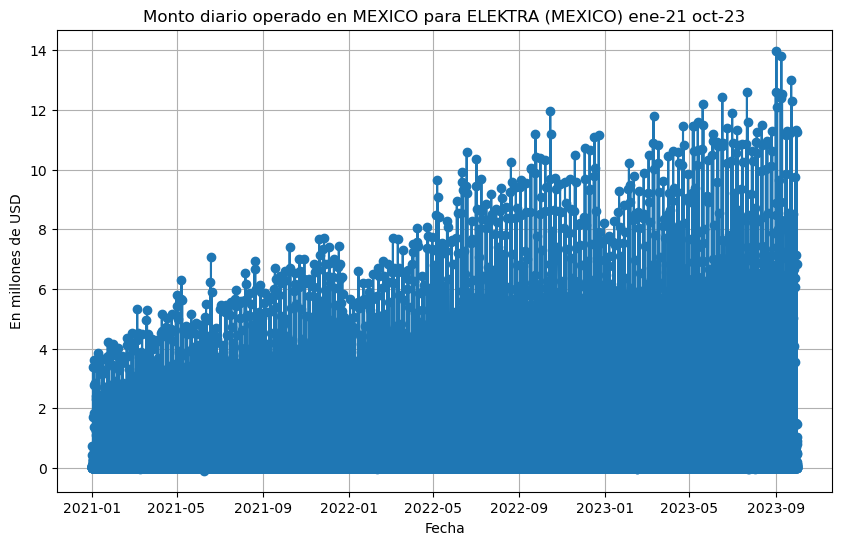

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_amount_daily(data, fecha_inicio, fecha_fin, pais=None, payer=None):
    # Eliminar espacios derechos de las variables COUNTRY y PAYER
    data['COUNTRY'] = data['COUNTRY'].str.rstrip()
    data['PAYER'] = data['PAYER'].str.rstrip()

    # Filtrar el DataFrame para las fechas y, opcionalmente, país y payer dados
    df_filtered = data[
        (data['DATE'] >= fecha_inicio) & 
        (data['DATE'] <= fecha_fin) & 
        (data['COUNTRY'] == pais) if pais else True & 
        (data['PAYER'] == payer) if payer else True
    ]

    # Ordenar el DataFrame por la columna DATE
    df_filtered = df_filtered.sort_values(by='DATE')

    # Graficar como serie de tiempo
    plt.figure(figsize=(10, 6))
    plt.plot(df_filtered['DATE'], df_filtered['AMOUNT']/ 1e6, marker='o')
    
    # Configuraciones adicionales para etiquetas y título
    title = f'Monto diario operado'
    if pais:
        title += f' en {pais}'
    if payer:
        title += f' para {payer} ene-21 oct-23'
    
    plt.title(title)
    plt.xlabel('Fecha')
    plt.ylabel('En millones de USD')
    plt.grid(True)
    plt.show()

fecha_inicio = pd.to_datetime('2021-01-01')
fecha_fin = pd.to_datetime('2023-10-01')
plot_amount_daily(df2, fecha_inicio, fecha_fin, pais="MEXICO", payer="ELEKTRA (MEXICO)")



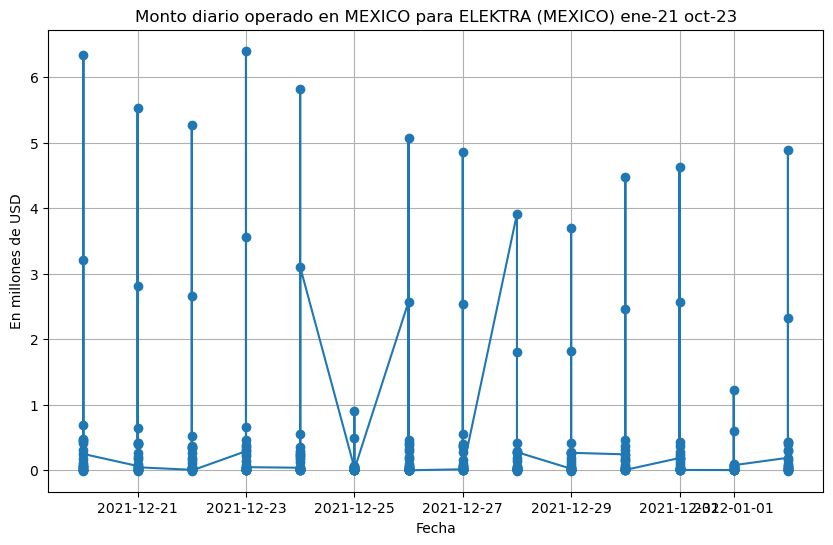

In [19]:
fecha_inicio = pd.to_datetime('2021-12-20')
fecha_fin = pd.to_datetime('2022-01-02')
plot_amount_daily(df2, fecha_inicio, fecha_fin, pais="MEXICO", payer="ELEKTRA (MEXICO)")

In [26]:
df[df['AMOUNT'] == 0]

,PAYER,COUNTRY,DATE,AMOUNT
6391,CREDOMATIC,PANAMA,2022-05-05,0.0
6402,DIRECT DEPOSIT (BTS),MEXICO,2022-10-16,0.0
6404,DIRECT DEPOSIT (BTS),MEXICO,2022-06-13,0.0
6405,MERCHANTRADE,THAILAND,2022-05-10,0.0
6414,MASTERCARD ATM NETWORK,UNITED STATES (ATM & DEPOSITS),2022-06-14,0.0
...,...,...,...,...
103663,JET PERU,SPAIN,2022-09-14,0.0
103665,DIRECT DEPOSIT (BTS),MEXICO,2021-09-24,0.0
103688,BBVA URUGUAY (BTS),URUGUAY,2022-10-22,0.0
103708,BANCO SANTANDER,MEXICO,2023-05-27,0.0


In [ ]:
##AGRUPAMOS MONTOS POR PAÍS Y DIA##

In [14]:
df3 = df.groupby(['COUNTRY', 'DATE']).agg({'AMOUNT': 'sum'}).reset_index()

In [15]:
df3.shape

(29367, 3)

/opt/conda/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


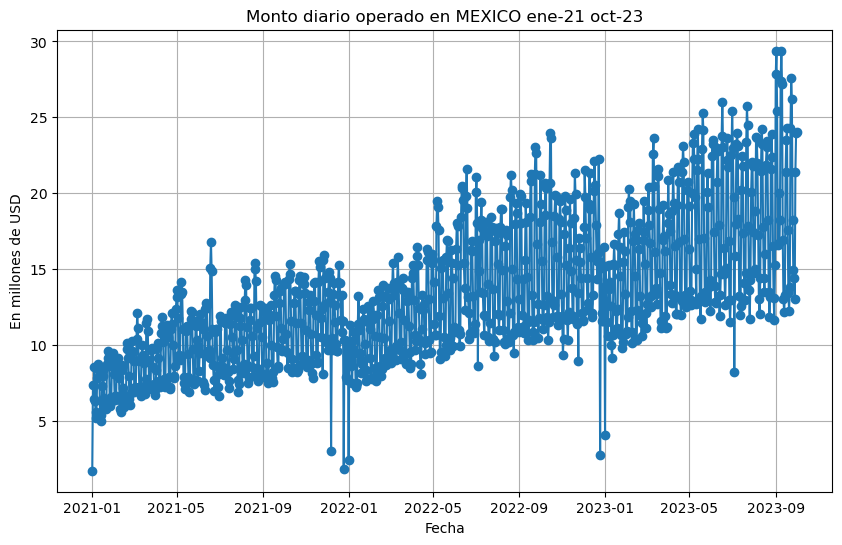

In [16]:
def plot_amount_daily(data, fecha_inicio, fecha_fin, pais="MEXICO"):
    # Filtrar el DataFrame para las fechas y país dados
    df_filtered = data[(data['DATE'] >= fecha_inicio) & (data['DATE'] <= fecha_fin) & (data['COUNTRY'] == pais)]

    # Ordenar el DataFrame por la columna DATE
    df_filtered = df_filtered.sort_values(by='DATE')

    # Graficar como serie de tiempo
    plt.figure(figsize=(10, 6))
    plt.plot(df_filtered['DATE'], df_filtered['AMOUNT']/ 1e6, marker='o')
    plt.title(f'Monto diario operado en {pais} ene-21 oct-23')
    plt.xlabel('Fecha')
    plt.ylabel('En millones de USD')
    plt.grid(True)
    plt.show()


fecha_inicio = pd.to_datetime('2021-01-01')
fecha_fin = pd.to_datetime('2023-10-01')
plot_amount_daily(df3, fecha_inicio, fecha_fin)  

In [11]:
df4 = df.groupby(['DATE']).agg({'AMOUNT': 'sum'}).reset_index()

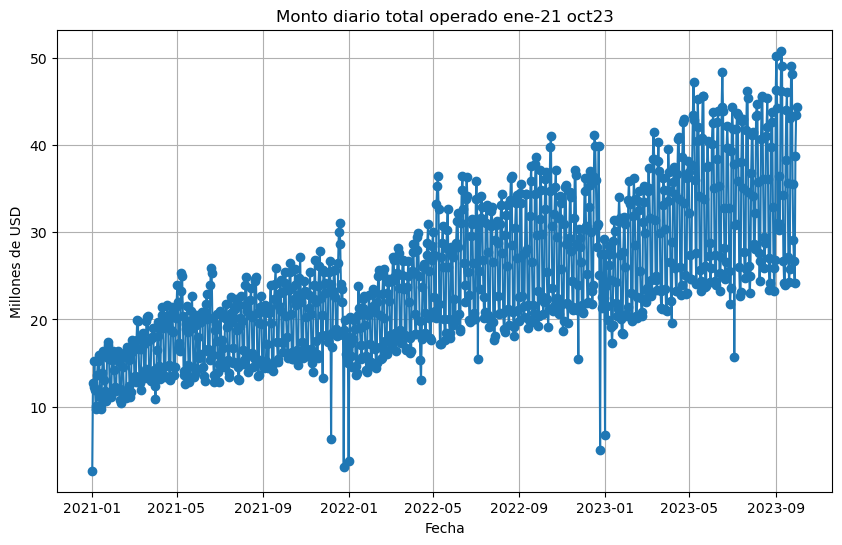

In [24]:
def plot_amount_daily(data, fecha_inicio, fecha_fin):
    # Filtrar el DataFrame para las fechas dadas
    df_filtered = data[(data['DATE'] >= fecha_inicio) & (data['DATE'] <= fecha_fin)]

    # Ordenar el DataFrame por la columna DATE
    df_filtered = df_filtered.sort_values(by='DATE')

    # Graficar como serie de tiempo
    plt.figure(figsize=(10, 6))
    plt.plot(df_filtered['DATE'], df_filtered['AMOUNT']/ 1e6, marker='o')
    plt.title('Monto diario total operado ene-21 oct23')
    plt.xlabel('Fecha')
    plt.ylabel('Millones de USD')
    plt.grid(True)
    plt.show()


fecha_inicio = pd.to_datetime('2021-01-01')
fecha_fin = pd.to_datetime('2023-10-01')
plot_amount_daily(df4, fecha_inicio, fecha_fin)


In [ ]:
## DATOS AGREGAMOS A NIVEL MENSUAL ##

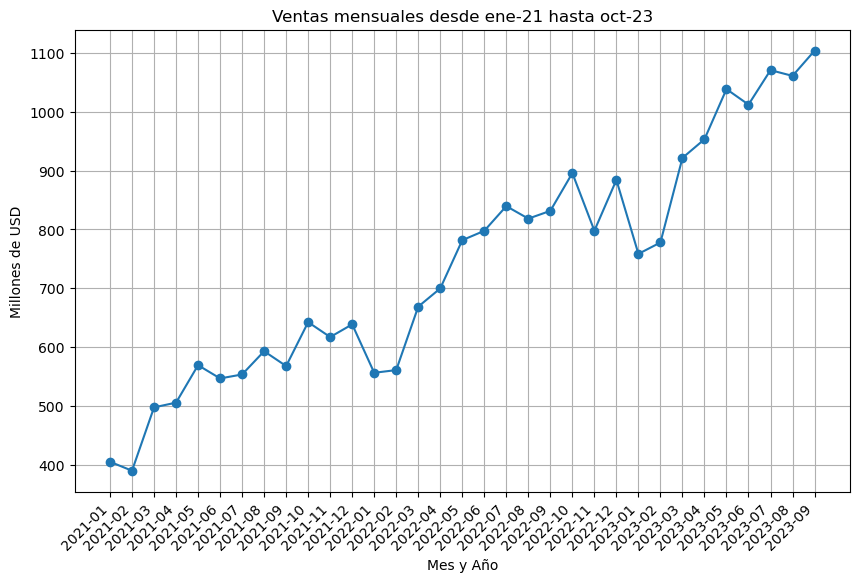

In [26]:
def plot_amount_monthly(data, fecha_inicio, fecha_fin):
    
    data['DATE'] = pd.to_datetime(data['DATE'])
    data['mes_año'] = data['DATE'].dt.strftime('%b %Y')
    # Filtrar el DataFrame para las fechas dadas
    df_filtered = data[(data['DATE'] >= fecha_inicio) & (data['DATE'] <= fecha_fin)]

    # Agrupar por mes-año y sumar las cantidades de transacciones
    df_grouped = df_filtered.groupby(df_filtered['DATE'].dt.to_period("M")).sum()

    # Graficar como serie de tiempo
    plt.figure(figsize=(10, 6))
    plt.plot(df_grouped.index.astype(str), df_grouped['AMOUNT']/1e6, marker='o', linestyle='-')
    plt.title('Ventas mensuales desde ene-21 hasta oct-23')
    plt.xlabel('Mes y Año')
    plt.ylabel('Millones de USD')
    plt.grid(True)
    plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mejorar la legibilidad
    plt.show()


fecha_inicio = pd.to_datetime('2021-01-01')
fecha_fin = pd.to_datetime('2023-09-30')
plot_amount_monthly(df4, fecha_inicio, fecha_fin)


In [ ]:
##INTENTO HACER LO MISMO PERO PARA CANTIDAD DE TRANSACCIONES (dejando afuera los casos con monto cero y las agencias virtuales)

In [30]:
from pyathena import connect
conn = connect(s3_staging_dir='s3://viamericas-datalake-dev-us-east-1-283731589572-athena/queryresults/',
               region_name='us-east-1')

df_tr = pd.read_sql(''' 
SELECT
    CAST(RTRIM(p.NAME_MAIN_BRANCH) AS VARCHAR(60)) AS PAYER,
    RTRIM(co.NAME_COUNTRY) AS COUNTRY,
    CAST(DATE_FORMAT(a.DATE_RECEIVER, '%Y-%m-%d') AS DATE) AS DATE,
    COUNT(CASE WHEN A.ID_FLAG_RECEIVER = 'A' THEN 0 ELSE a.NET_AMOUNT_RECEIVER END) AS AMOUNT
FROM
    AwsDataCatalog.viamericas.RECEIVER a
    INNER JOIN AwsDataCatalog.viamericas.GROUP_BRANCH p ON p.ID_MAIN_BRANCH = CASE WHEN a.ID_MAIN_BRANCH_EXPIRED IS NULL THEN RTRIM(a.ID_MAIN_BRANCH_SENT) ELSE RTRIM(a.ID_MAIN_BRANCH_EXPIRED) END
    INNER JOIN AwsDataCatalog.viamericas.COUNTRY co ON a.ID_COUNTRY_RECEIVER = co.ID_COUNTRY
    LEFT JOIN AwsDataCatalog.viamericas.BRANCH b ON a.ID_BRANCH = b.ID_BRANCH
WHERE
    NOT (A.ID_MAIN_BRANCH_SENT LIKE 'M%')
    AND NOT (A.ID_BRANCH LIKE 'T%')
    AND SUBSTRING(b.id_branch, 1, 1) IN (SELECT SUBSTRING(PREFIX, 1, 1) FROM AwsDataCatalog.viamericas.BRANCH_PREFIX P WHERE TRIM(B.ID_COUNTRY) = TRIM(P.ID_COUNTRY))
    AND A.DATE_RECEIVER >= TIMESTAMP '2020-12-31 00:00:00.000'
    AND A.DATE_RECEIVER < TIMESTAMP '2023-10-31 00:00:00.000'
    AND b.ID_LOCATION IS NOT NULL
    AND b.ID_LOCATION NOT IN ('MD0010', 'MD0952', 'AK0003', 'CA3897', 'NY1130', 'MD0696', 'FL1933', 'AK0004', 'CA4046', 'NY1221', 'MD0623', 'MD1003', 'MD1018', 'AK0008', 'CA4291', 'NY1346', 'CA4350', 'NY1381','OK0236','FL2287','CA4391','AK0009', 'NY1397','CA4392','AK0010','FL2288','NY1399','AK0012','CA4396','NY1402','FL2289','AK0013', 'CA4418','NY1410','FL2301','AK0014', 'CA4428', 'NY1413')
    AND a.NET_AMOUNT_RECEIVER <> 0
GROUP BY
    RTRIM(p.NAME_MAIN_BRANCH),
    RTRIM(co.NAME_COUNTRY),
    CAST(DATE_FORMAT(a.DATE_RECEIVER, '%Y-%m-%d') AS DATE)
''', conn)

/opt/conda/lib/python3.10/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [44]:
df_control2=df_tr.loc[df_tr.PAYER=="ENVIOS CON CLABE (APPRIZA)"]

In [45]:
df_control2.AMOUNT.sum()

1433637

In [97]:
#df_tr.AMOUNT.sum() (2240454 junio 23)

2240454

In [33]:
df_tr2=df_tr.loc[df_tr.COUNTRY=='MEXICO']
df_tr2.shape

(22705, 4)

In [34]:
df_tr2.AMOUNT.sum()
##MISMO VALOR JUNIO 2023!!! 1129453##

30221239

In [35]:
df_tr2.head(1)

,PAYER,COUNTRY,DATE,AMOUNT
2,BBVA - BANCOMER (BTS),MEXICO,2023-03-17,1799


In [ ]:
##GRAFICAMOS LA EVOLUCIÓN DE LAS TRANSACCIONES A NIVEL AGREGADO DESDE ENERO 2021

In [36]:
df_tr3 = df_tr.groupby(['DATE']).agg({'AMOUNT': 'sum'}).reset_index()

/opt/conda/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


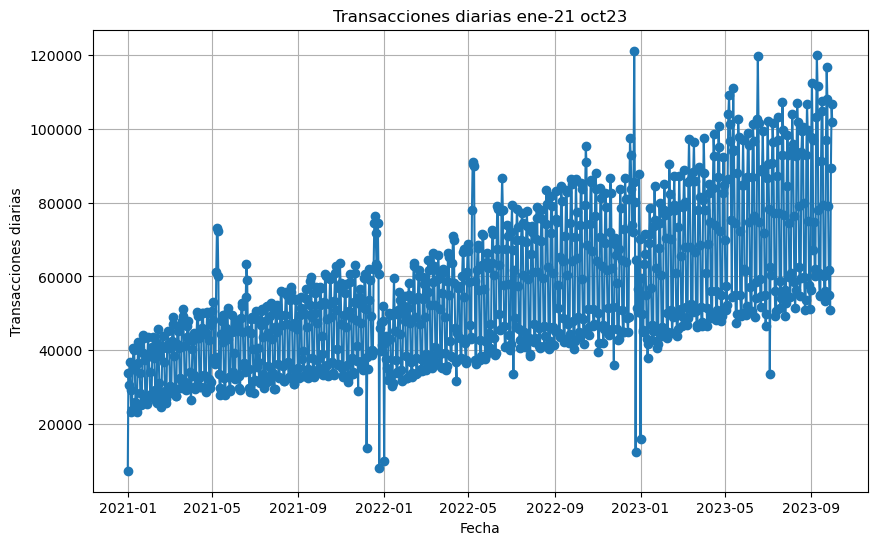

In [37]:
def plot_amount_daily(data, fecha_inicio, fecha_fin):
    # Filtrar el DataFrame para las fechas dadas
    df_filtered = data[(data['DATE'] >= fecha_inicio) & (data['DATE'] <= fecha_fin)]

    # Ordenar el DataFrame por la columna DATE
    df_filtered = df_filtered.sort_values(by='DATE')

    # Graficar como serie de tiempo
    plt.figure(figsize=(10, 6))
    plt.plot(df_filtered['DATE'], df_filtered['AMOUNT'], marker='o')
    plt.title('Transacciones diarias ene-21 oct23')
    plt.xlabel('Fecha')
    plt.ylabel('Transacciones diarias')
    plt.grid(True)
    plt.show()


fecha_inicio = pd.to_datetime('2021-01-01')
fecha_fin = pd.to_datetime('2023-10-01')
plot_amount_daily(df_tr3, fecha_inicio, fecha_fin)


In [ ]:
##GRAFICAMOS LAS TRANSACCIONES MENSUALES

In [38]:
df_tr3['DATE'] = pd.to_datetime(df_tr3['DATE'])
df_tr3['mes_año'] = df_tr3['DATE'].dt.strftime('%b %Y')

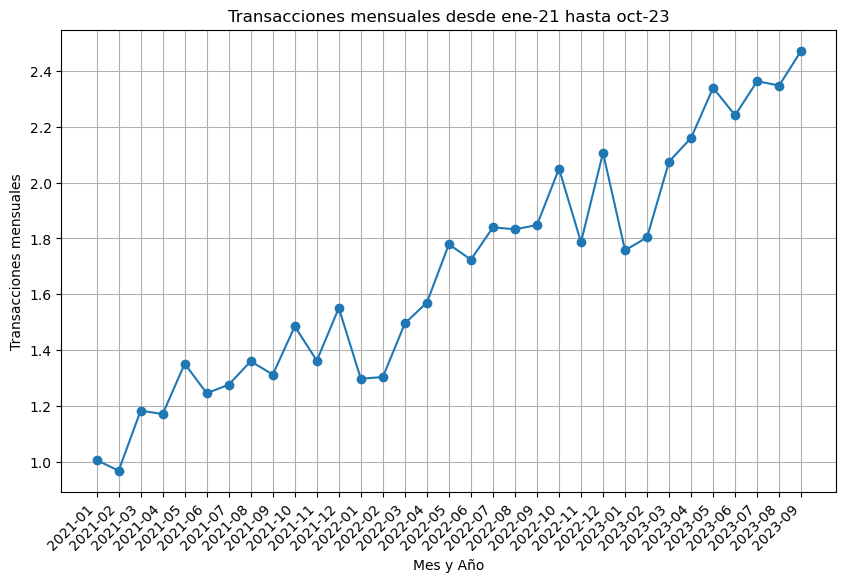

In [39]:
def plot_amount_monthly(data, fecha_inicio, fecha_fin):
    # Filtrar el DataFrame para las fechas dadas
    df_filtered = data[(data['DATE'] >= fecha_inicio) & (data['DATE'] <= fecha_fin)]

    # Agrupar por mes-año y sumar las cantidades de transacciones
    df_grouped = df_filtered.groupby(df_filtered['DATE'].dt.to_period("M")).sum()

    # Graficar como serie de tiempo
    plt.figure(figsize=(10, 6))
    plt.plot(df_grouped.index.astype(str), df_grouped['AMOUNT']/1e6, marker='o', linestyle='-')
    plt.title('Transacciones mensuales desde ene-21 hasta oct-23')
    plt.xlabel('Mes y Año')
    plt.ylabel('Transacciones mensuales')
    plt.grid(True)
    plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mejorar la legibilidad
    plt.show()


fecha_inicio = pd.to_datetime('2021-01-01')
fecha_fin = pd.to_datetime('2023-09-30')
plot_amount_monthly(df_tr3, fecha_inicio, fecha_fin)




In [ ]:
##MISMOS DATOS PERO EN TABLA"

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

def get_amount_monthly_table(data, fecha_inicio, fecha_fin):
    # Filtrar el DataFrame para las fechas dadas
    df_filtered = data[(data['DATE'] >= fecha_inicio) & (data['DATE'] <= fecha_fin)]

    # Agrupar por mes-año y sumar las cantidades de transacciones
    df_grouped = df_filtered.groupby(df_filtered['DATE'].dt.to_period("M")).sum()

    # Crear una tabla de transacciones mensuales
    table_data = df_grouped.reset_index().rename(columns={'DATE': 'Mes y Año'})
    table = pd.DataFrame(table_data.values, columns=table_data.columns)
    
    return table


fecha_inicio = pd.to_datetime('2021-01-01')
fecha_fin = pd.to_datetime('2023-10-01')
monthly_table = get_amount_monthly_table(df_tr3, fecha_inicio, fecha_fin)

# Imprimir el DataFrame resultante
print(monthly_table)

   Mes y Año   AMOUNT
0    2021-01  1006628
1    2021-02   968537
2    2021-03  1183628
3    2021-04  1171256
4    2021-05  1351454
5    2021-06  1246044
6    2021-07  1276281
7    2021-08  1360508
8    2021-09  1312427
9    2021-10  1485153
10   2021-11  1362548
11   2021-12  1550755
12   2022-01  1297712
13   2022-02  1303883
14   2022-03  1495631
15   2022-04  1570547
16   2022-05  1779082
17   2022-06  1723876
18   2022-07  1839553
19   2022-08  1832688
20   2022-09  1847780
21   2022-10  2049442
22   2022-11  1786367
23   2022-12  2106399
24   2023-01  1757389
25   2023-02  1803790
26   2023-03  2074855
27   2023-04  2159707
28   2023-05  2339030
29   2023-06  2240454
30   2023-07  2362753
31   2023-08  2347056
32   2023-09  2471746
33   2023-10   101739


In [ ]:
##AHORA ESTIMAMOS LA ANTIGUEDAD AL ULTIMO DATO DISPONIBLE DE LOS PAYERS DESDE ENERO 2021##

In [49]:
def calculate_antiguedad(data, fecha_inicio, fecha_fin):
    # Convert the date column to datetime objects
    data['DATE'] = pd.to_datetime(data['DATE'])
    
    # Filter the DataFrame based on the provided date range
    filtered_data = data[(data['DATE'] >= fecha_inicio) & (data['DATE'] <= fecha_fin)]
    
    # Find the first and last date for each payer
    payer_summary = filtered_data.groupby(['PAYER', 'COUNTRY'])['DATE'].agg(['min', 'max']).reset_index()
    
    # Calculate the antiguedad as the difference in months between the first and last date
    payer_summary['ANTIGUEDAD'] = ((payer_summary['max'] - payer_summary['min']) / pd.Timedelta(days=30)).astype(int)
    
    # Include all payers in the result, filling missing values with 0 for ANTIGUEDAD
    all_payers = pd.DataFrame(data['PAYER'].unique(), columns=['PAYER'])
    result_df = pd.merge(all_payers, payer_summary, on='PAYER', how='left').fillna(0)
    
    # Sort the DataFrame by ANTIGUEDAD in descending order
    result_df = result_df.sort_values(by='ANTIGUEDAD', ascending=False)
    
    return result_df


fecha_inicio = pd.to_datetime('2021-01-01')
fecha_fin = pd.to_datetime('2023-12-31')

result_df = calculate_antiguedad(df_tr, fecha_inicio, fecha_fin)
print(result_df)

                          PAYER      COUNTRY        min        max  ANTIGUEDAD
7    FARMACIAS GUADALAJARA (UT)       MEXICO 2021-01-01 2023-10-21          34
6       FEDECACES (EL SALVADOR)  EL SALVADOR 2021-01-01 2023-10-21          34
5            BANCO DE ORO (BDO)  PHILIPPINES 2021-01-01 2023-10-21          34
21                    OXXO (TN)       MEXICO 2021-01-01 2023-10-21          34
22                       AIRPAK       MEXICO 2021-01-01 2023-10-21          34
..                          ...          ...        ...        ...         ...
252                         BNB        GHANA 2023-10-05 2023-10-06           0
295              WOOLWORTH (UT)       MEXICO 2023-09-06 2023-09-15           0
296                   HAITI PAY        HAITI 2022-05-02 2022-05-03           0
297             OLD- TIGO MONEY    GUATEMALA 2021-04-11 2021-04-11           0
298        RED CHAPINA ANYWHERE    GUATEMALA 2023-08-23 2023-08-23           0

[299 rows x 5 columns]


In [58]:
result2_df=result_df.loc[result_df.ANTIGUEDAD=]
result2_df.shape

(47, 5)